In [1]:
import os
from torchvision.transforms import Pad

## Dataset Object Definition + Creation

In [2]:
import os
import nibabel as nib
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import Pad
from torchvision.transforms import ToTensor, Compose

def pad_to_max_size(image, max_size):
    padding = [0, 0, max_size - image.shape[1], max_size - image.shape[0]]  # Pad width and height to max size
    return Pad(padding)(image)  # Pad needs a 4-element tuple (left, top, right, bottom)

class ProstateMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        # Iterate through all the folders in the root directory
        for subject in os.listdir(self.root_dir):
            subject_path = os.path.join(self.root_dir, subject)
            if os.path.isdir(subject_path):
                mri_path = os.path.join(subject_path, 'T2.nii.gz')
                mask_path = os.path.join(subject_path, 'prostate_mask.nii.gz')
                if os.path.isfile(mri_path) and os.path.isfile(mask_path):
                    mri_img = nib.load(mri_path).get_fdata().astype(np.float32)
                    mask_img = nib.load(mask_path).get_fdata().astype(np.float32)
                    mri_img = mri_img / np.max(mri_img)  # Normalize MRI images

                    # Iterate through each slice and check the mask
                    for slice_idx in range(mri_img.shape[-1]):
                        if np.any(mask_img[:, :, slice_idx] > 0):  # Check if mask is not all zeros
                            samples.append((mri_img[:, :, slice_idx], mask_img[:, :, slice_idx]))

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        mri_slice, mask_slice = self.samples[idx]

        # Convert numpy arrays to PIL images
        mri_pil = Image.fromarray(mri_slice)
        mask_pil = Image.fromarray(mask_slice)
        
        max_size = 620

        # Define the transform which includes converting to tensor after padding
        transform = Compose([
            Pad((0, 0, max_size - mri_slice.shape[1], max_size - mri_slice.shape[0]), fill=0),
            ToTensor()
        ])

        # Apply the transform
        mri_tensor = transform(mri_pil)
        mask_tensor = transform(mask_pil)

        return mri_tensor, mask_tensor

        return mri_slice, mask_slice

In [3]:
# Specify the root directory of the dataset
root_dir = '/data/csc4801/LaVioletteLab/LaVioletteData/'

# Initialize the dataset
prostate_dataset = ProstateMRIDataset(root_dir=root_dir)

## Display Sample For Sanity Check

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

def load_nifti_file(file_path):
    """Load a NIfTI file and return its data."""
    nifti_img = nib.load(file_path)
    return nifti_img.get_fdata()

def display_slice_and_mask(slice_img, mask_img):
    """Display a slice and its mask."""
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(slice_img, cmap='gray')
    ax[0].set_title('MRI Slice')
    ax[1].imshow(mask_img, cmap='gray')
    ax[1].set_title('Mask')
    ax[2].imshow(slice_img, cmap='gray')
    ax[2].imshow(mask_img, alpha=0.5, cmap='Reds')  # Overlay the mask in red
    ax[2].set_title('Overlay')
    for a in ax:
        a.axis('off')
    plt.show()

# Specify the paths to your MRI and mask files
subject_dir = '/data/csc4801/LaVioletteLab/LaVioletteData/1101'  # Replace with the path to a specific subject folder
mri_path = os.path.join(subject_dir, 'T2.nii.gz')
mask_path = os.path.join(subject_dir, 'prostate_mask.nii.gz')

# Load the MRI and mask volumes
mri_volume = load_nifti_file(mri_path)
mask_volume = load_nifti_file(mask_path)

# Extract a middle slice from the volumes
middle_slice_idx = mri_volume.shape[2] // 2
print(middle_slice_idx)
middle_slice_idx = 13
slice_img = mri_volume[:, :, middle_slice_idx]
mask_img = mask_volume[:, :, middle_slice_idx]

# Display the slice, mask, and overlay
display_slice_and_mask(slice_img, mask_img)


16


## Model

In [ ]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [6]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [8]:
# Create the model
model = UNet(1, 1)

# Assuming we're using GPU for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

## Loop

In [9]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

batch_size = 8

# Assuming prostate_dataset is an instance of ProstateMRIDataset
dataset_size = len(prostate_dataset)
train_size = int(dataset_size * 0.8)  # 80% of the dataset for training
validation_size = dataset_size - train_size  # 20% for validation

# Split the dataset
train_dataset, validation_dataset = random_split(prostate_dataset, [train_size, validation_size])

# Initialize DataLoaders for train and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


In [10]:
import gc
gc.collect()

2343

In [10]:
from tqdm.notebook import tqdm

# Set the model to training mode
model.train()

# Number of epochs
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    # Training phase
    model.train()
    train_progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Epoch {epoch+1}/{num_epochs}, Train')
    for batch_idx, (mri, mask) in train_progress_bar:
        # Transfer to GPU if available
        mri = mri.to(device)
        mask = mask.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = model(mri)

        # Compute loss
        loss = criterion(outputs, mask)

        # Perform backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item()
        train_progress_bar.set_postfix({'loss': running_loss/(batch_idx+1)})

    # Validation phase
    model.eval()  # Set model to evaluation mode
    validation_loss = 0.0
    with torch.no_grad():
        validation_progress_bar = tqdm(enumerate(validation_dataloader), total=len(validation_dataloader), desc=f'Epoch {epoch+1}/{num_epochs}, Val')
        for batch_idx, (mri, mask) in validation_progress_bar:
            mri = mri.to(device)
            mask = mask.to(device)

            outputs = model(mri)
            loss = criterion(outputs, mask)

            validation_loss += loss.item()
            validation_progress_bar.set_postfix({'val_loss': validation_loss/(batch_idx+1)})

print('Finished Training')


Epoch 20/20, Val: 100%|██████████| 69/69 [00:23<00:00,  2.95it/s, val_loss=0.02]  

Finished Training


In [16]:
# torch.save(model, 'model_e20_l02')

In [11]:
model = torch.load('model_e20_l02')

## Predictions

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def calculate_iou(pred, target):
    pred_bool = pred.bool()
    target_bool = target.bool()
    intersection = (pred_bool & target_bool).sum((1, 2))  # Corrected for boolean tensors
    union = (pred_bool | target_bool).sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)  # Avoid division by zero
    return iou.mean()  # Average IoU for the batch

def calculate_dice(pred, target):
    pred_bool = pred.bool()
    target_bool = target.bool()
    intersection = (pred_bool & target_bool).sum((1, 2))
    dice = (2. * intersection + 1e-6) / (pred.sum((1, 2)) + target.sum((1, 2)) + 1e-6)
    return dice.mean()  # Average Dice Coefficient for the batch

def visualize_and_metrics(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        for mri, mask in dataloader:
            mri = mri.to(device)
            mask = mask.to(device)
            pred = model(mri)
            pred = torch.sigmoid(pred)  # Apply sigmoid to get probabilities
            pred_binary = (pred > 0.5).type(torch.int)  # Convert probabilities to binary mask
            
            # Calculate metrics
            iou = calculate_iou(pred_binary, mask)
            dice = calculate_dice(pred_binary, mask)
            
            # Randomly select an image from the batch
            batch_size = mri.shape[0]
            rand_index = random.randint(0, batch_size - 1)
            
            # Convert selected image and mask to numpy for visualization
            mri_np = mri.cpu().numpy()[rand_index, 0]  # Random image, first channel
            mask_np = mask.cpu().numpy()[rand_index, 0]  # Corresponding mask
            pred_np = pred_binary.cpu().numpy()[rand_index, 0]  # Corresponding prediction
            
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(mri_np, cmap='gray')
            plt.title('MRI Image')
            plt.subplot(1, 3, 2)
            plt.imshow(pred_np, cmap='gray')
            plt.title('Predicted Mask')
            plt.subplot(1, 3, 3)
            plt.imshow(mask_np, cmap='gray')
            plt.title('Actual Mask')
            plt.show()
            
            print(f'IoU: {iou.item():.4f}, Dice Coefficient: {dice.item():.4f}')
            break  # Only visualize for the first batch for simplicity


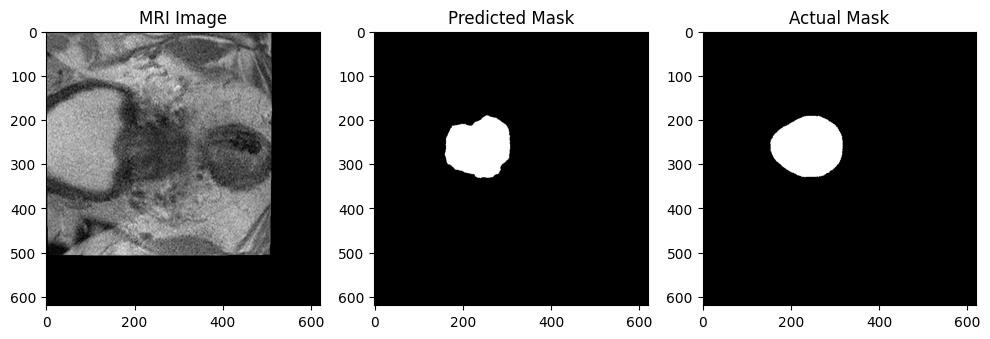

IoU: 0.9681, Dice Coefficient: 0.9747


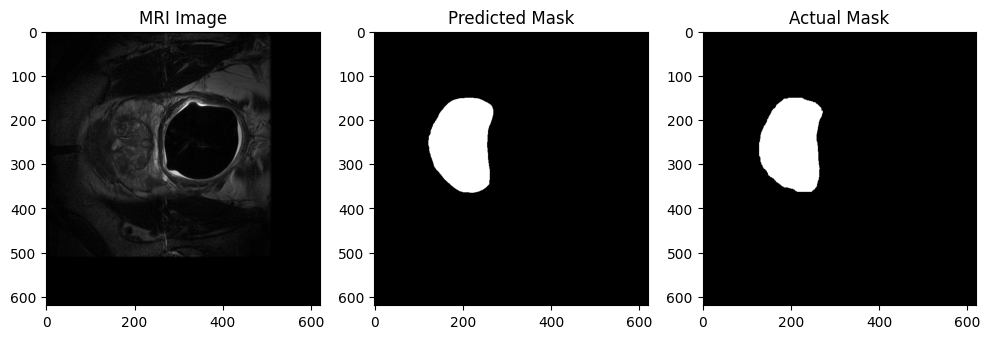

IoU: 0.9759, Dice Coefficient: 0.9825


In [13]:
visualize_and_metrics(model, validation_dataloader, device)
visualize_and_metrics(model, train_dataloader, device)


## Problem Children

In [14]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def find_and_plot_worst_performing_images(model, dataloader, device, percentage=5):
    model.eval()
    scores = []  # Store (image_id, IoU, Dice, mri, mask, pred_binary)
    
    with torch.no_grad():
        # Wrap dataloader with tqdm for a progress bar
        for idx, (mri, mask) in enumerate(tqdm(dataloader, desc="Processing images")):
            mri = mri.to(device)
            mask = mask.to(device)
            pred = model(mri)
            pred = torch.sigmoid(pred)
            pred_binary = (pred > 0.5).type(torch.int)
            
            # Calculate IoU and Dice scores
            iou = calculate_iou(pred_binary, mask).item()
            dice = calculate_dice(pred_binary, mask).item()
            
            # Store scores and images
            scores.append((idx, iou, dice, mri.cpu(), mask.cpu(), pred_binary.cpu()))
    
    # Sort scores based on IoU and Dice, then find threshold
    scores.sort(key=lambda x: (x[1], x[2]))  # Sort by IoU, then Dice
    threshold_index = int(len(scores) * (percentage / 100))
    
    # Select the worst-performing images
    worst_performing_images = scores[:threshold_index]
    
    # Plot each selected image with its predicted and actual mask
    for idx, iou, dice, mri, mask, pred_binary in tqdm(worst_performing_images, desc="Plotting images"):
        mri_np = mri.numpy()[0, 0]  # Assuming the first channel and first image
        mask_np = mask.numpy()[0, 0]
        pred_np = pred_binary.numpy()[0, 0]
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(mri_np, cmap='gray')
        plt.title('MRI Image')
        plt.subplot(1, 3, 2)
        plt.imshow(pred_np, cmap='gray')
        plt.title(f'Predicted Mask\nIoU: {iou:.4f}, Dice: {dice:.4f}')
        plt.subplot(1, 3, 3)
        plt.imshow(mask_np, cmap='gray')
        plt.title('Actual Mask')
        plt.show()

    return worst_performing_images


Processing images:   0%|          | 0/69 [00:00<?, ?it/s]

Plotting images:   0%|          | 0/3 [00:00<?, ?it/s]

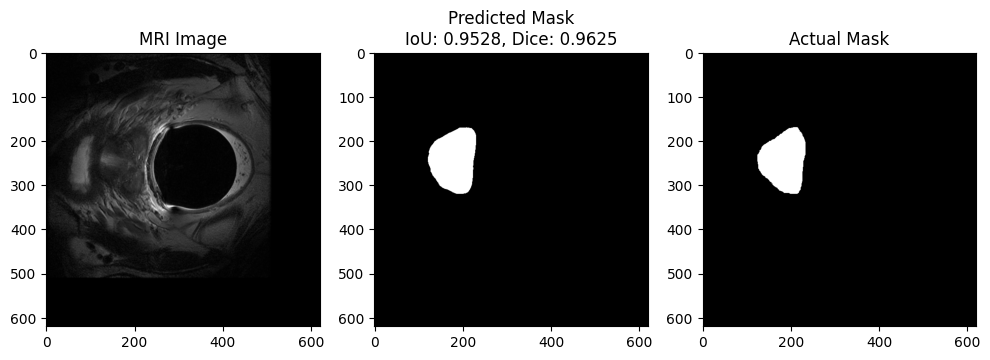

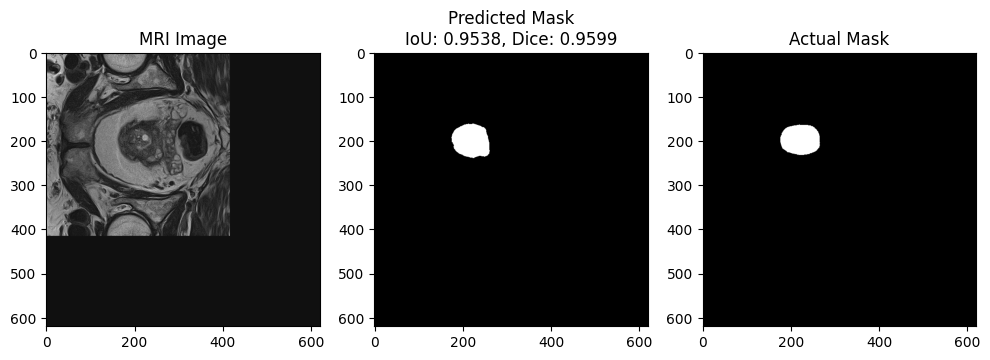

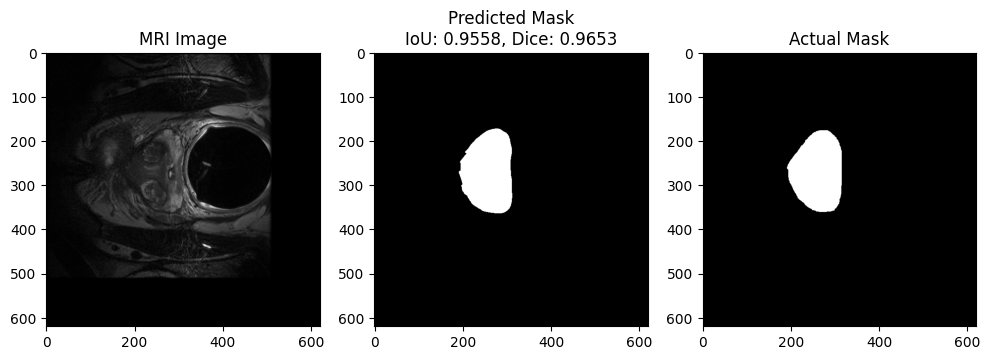

In [15]:
worst_performing_images = find_and_plot_worst_performing_images(model, validation_dataloader, device, percentage=5)
